# MapAnalyzer - Demo

## Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
import uts    # Import the uts.py module

## Setup

In [2]:
# Define a dictionary `params`, which contains all information necessary to create a MapAnalyzer object

params = {
    'id': 'map_data_1',    # Unique id for the dataset
    'folder': r'.\data_map_analyzer',    # Folder containing the EDX data
    'description': {    # Description of each individual EDX map
        'A1': 'on zone',
        'A2': 'partially on zone',
        'A3': 'off zone'
    },
    'all_elements': ['Ga', 'As', 'Sb', 'Cu', 'C', 'O', 'Si', 'Fe'],    # Specify all elements which are present in the samples. Useful when plotting spectra.
    'pre_processing': lambda x: x.sum('y'),    # Apply some function to each EDX map before . Often, it is useful to sum the map over one of the axes or rebin the signal.
    'pca': 3,   # Specify the number of PCA components to use. If PCA is not used, then specify `None`.
    'beam_current': 0.38,    # Supply beam currents as a dictionary in the format {'A1': 1.15, 'A2': 1.18, ...}. Alternatively, specify that you want to obtain beam currents from .dm3 measurement files; then, write 'from_measurement_files'.
    'intensity': 'model_fitting', # Either `model_fitting` or `window_method`. Specifies how the X-ray intensities should be retrieved from the EDX spectra
    'mod_lim': slice(2.5, 20.0),    # If model fitting: Specify the energy range (in keV) which is used for model fitting.
    'mod_elements': ['As', 'Cu', 'Ga', 'Sb'],    # If model fitting: Specify which elements should be model fitted.
    'composition': lambda x: {'Ga': 0.5, 'As': 0.5},    # Sample composition at each region, in at%. Internally, the compositions are converted to wt%.
    'zone_tilt': -1.46,    # Stage tilt (in degrees) at which the nanowire is orthogonal to the electron beam (110 zone axis). Used for thickness correction.
    'thickness': lambda x: uts.get_thickness(x, 97.0e-9, params['zone_tilt'], hexagonal=True), # Lambda function for retrieving thickness from each signal
    'density': 5317.6,    # Density of GaAs, in kg/m^3
    'xray_lines': ['Ga_Ka', 'As_Ka', 'Sb_La'] # X-ray lines to find zeta-factors from
}

In [3]:
# Calibration function, which e.g. can be used to line up multiple maps relative to each other
def calibration(s):
    if uts.get_label(s) == 'A2':
        s.axes_manager['x'].offset = 4
    if uts.get_label(s) == 'A3':
        s.axes_manager['x'].offset = 30

In [4]:
# Create the MapAnalyzer object
a = uts.MapAnalyzer(params, calibration)

Loading signals...Done
Changing datatype...Done
Applying pre-processing step...Done
Changing datatype...Done
Applying pre-processing step...Done
Changing datatype...Done
Applying pre-processing step...Done
Retrieving PCA results for signal A1 from cache.
Retrieving PCA results for signal A2 from cache.
Retrieving PCA results for signal A3 from cache.
Loading model fitting results from cache


## Analysis

Plot intensities

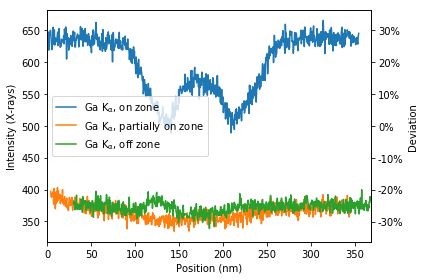

In [5]:
# Plot the Ga_Ka intensities
fig, ax = a.plot_intensities(xray_lines=['Ga_Ka'])
uts.add_deviation(ax)

Plot zeta-factors

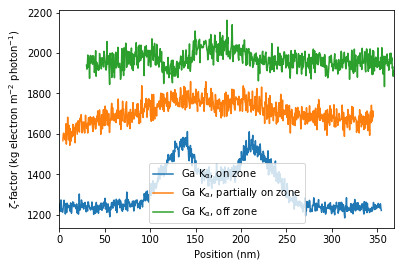

In [6]:
fig, ax = a.plot_zetas(xray_lines=['Ga_Ka'], option='absolute')

## Calculate compositions

Determine internal zeta-factors from ROIs

In [7]:
z_ga = a.determine_zeta_factor('A3', 'Ga_Ka', option='absolute')

In [8]:
print(z_ga)

{'xray_line': 'Ga_Ka', 'label': 'A3', 'zeta': 1969.4744352668947, 'std': 45.83804518599158}


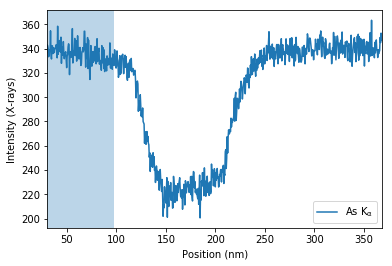

In [9]:
# The ROIs are specified as a list of tuples. Multiple tuples can be supplied. The tuple arguments are the relative position on the map; 0 is to the left, and 1 is to the right.
z_as = a.determine_zeta_factor('A3', 'As_Ka', option='absolute', rois=[(0, 0.2)], plot=True)

In [10]:
print(z_as)

{'xray_line': 'As_Ka', 'label': 'A3', 'zeta': 2348.1869449833976, 'std': 55.34969932296795}


Composition from tuned zeta-factors

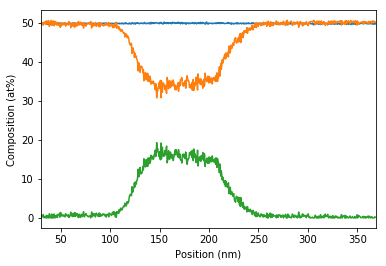

In [11]:
z_sb = {'xray_line': 'Sb_La', 'zeta': 3070}
fig, ax = a.plot_composition(['A3'], 'zeta', {'Ga_Ka': z_ga, 'As_Ka': z_as, 'Sb_La': z_sb}, legend=False)

Composition from tabulated zeta-factors

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x23d848e9278>)

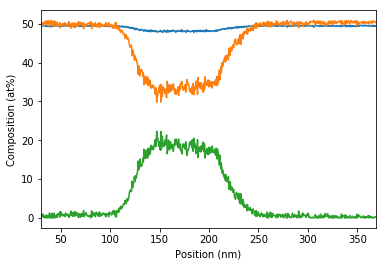

In [12]:
a.plot_composition(['A3'], 'zeta', {'Ga_Ka': 1628, 'As_Ka': 1963, 'Sb_La': 3070}, legend=False)

Composition by the Cliff-Lorimer method

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x23d849d53c8>)

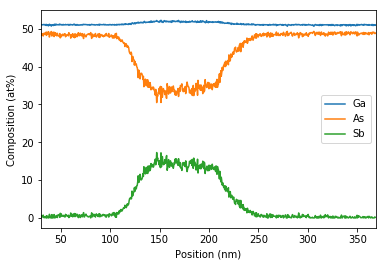

In [13]:
a.plot_composition(['A3'], 'CL', {'Ga_Ka': 1.444, 'As_Ka': 1.636, 'Sb_La': 1.935})